This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework_4/blob/main/Assignment_4_Transformers.ipynb)



# Dependencies

In [ ]:
!pip install -U spacy==3.6.0
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install torchdata
!pip install -U torchtext
!pip install portalocker>=2.0.0
!pip install seaborn

# Transformer Assignment

## Overview

In this assignment, you will be trying your hand at understanding transformers, their architecture, and their difference in-terms of basic RNNs. The assignment is divided in 2 sections.


*   Section 1:

 You will be implmenting a basic RNN cell, RNN Class and an RNN Classifier


*   Section 2:

  You will be implementing a Transformer based Text classifier using components such as Multi-head Attention Module, Positional Encoding Module and Encoder

*   Section 3:

  In order to experiment with Decoders for a Transformer, we will be implementing a Transformer Based Machine Translation class using modules of Section 2, a Decoder, Attention Masks and Seq-Seq Module

In [ ]:
import math
import torch
import time

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

# Section 1: Recurrent Neural Networks (RNN)



Each RNN Cell should contain 2 components: an Input Unit and a Hidden Unit. The Hidden state is the part of the RNN that remembers context about previous data present in the sequence. The current time step's hidden state is calculated using information of the previous time steps hidden state and the current input. This process helps to retain information on what the model saw in the previous time step when processing the current time steps information.

RNNs will look and function as follows,

<img src="images\RNN Multi.png">

The hidden state any given time *t* is given by,

\begin{align}
input_t &= (x_t \cdot W_x^t + b_x^t) \\
prev\_state &= (h_{t-1} \cdot W^t_h + b_h^t) \\
\end{align}


\begin{align}
h_{t} &= tanh( input_t+ prev\_state)
\end{align}

The output at any give time *t* is given by,

\begin{align}
y_t = h_t \cdot W_y^t + b_y
\end{align}

Note:  All the connections in RNN have weights and biases.

Your job is to implement the formulae above.

## 1.1 A Single RNN Cell

In [ ]:
class RNNCell(torch.nn.Module):
    """
    RNNCell is a single cell that takes x_t and h_{t_1} as input and outputs h_t.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of RNNCell.

        Inputs:
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """

        # We always need to do this step to properly implement the constructor
        super(RNNCell, self).__init__()

        self.linear_x, self.linear_h, self.non_linear = None, None, None

        ###########################################################################
        # TODO:
        # 1. Define the linear transformation layers for the attributes
        #    (set to None above) to correspond to the W_x and W_h in the formulae.
        #    Remember to include bias in the linear layers.
        #    (Refer to nn.Linear documentation https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
        # 2. Define the non_linear layer. (You can use tanh as describe bove).
        ###########################################################################


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x_cur: torch.Tensor, h_prev: torch.Tensor):
        """
        Compute h_t given x_t and h_{t-1}.

        Inputs:
        - x_cur: x_t, a tensor with the same of BxC, where B is the batch size and
          C is the channel dimension.
        - h_prev: h_{t-1}, a tensor with the same of BxH, where H is the channel
          dimension.
        """
        h_cur = None
        ###########################################################################
        # TODO: Run the linear transformation layers to compute x_t and consume
        # h_{t-1}               #
        # go  non-linear layer.                                                   #
        ###########################################################################

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return h_cur

In [ ]:
# Let's run a sanity check of your model
x = torch.randn((2, 8)) # Input Dim
h = torch.randn((2, 16)) # Hidden Dim

model = RNNCell(8, 16)
y = model(x , h)
assert len(y.shape) == 2 and y.shape[0] == 2 and y.shape[1] == 16
print(y.shape)

## 1.2 RNN Layer

In [ ]:
class RNN(torch.nn.Module):
    """
    RNN is a single-layer (stack) RNN by connecting multiple RNNCell together in a single
    direction, where the input sequence is processed from left to right.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of the RNN module.

        Inputs:
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim

        ###########################################################################
        # TODO: Define the RNNCell.                                               #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Compute the hidden representations for every token in the input sequence.

        Input:
        - x: A tensor with the shape of BxLxC, where B is the batch size, L is the squence
          length, and C is the channel dimmension

        Return:
        - h: A tensor with the shape of BxLxH, where H is the hidden dimension of RNNCell
        """
        b = x.shape[0]
        seq_len = x.shape[1]

        # initialize the hidden dimension
        init_h = x.new_zeros((b, self.hidden_dim))
        h = None
        ###########################################################################
        # TODO: Compute the hidden representation for every token in the input    #
        # from left to right as per the formula stated above                      #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return h

In [ ]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
model = RNN(8, 16)
y = model(x)
assert len(y.shape) == 3
for dim, dim_gt in zip(y.shape, [2, 10, 16]):
    assert dim == dim_gt
print(y.shape)

## 1.3 RNN Classifier

In [ ]:
h_tracker = {}

class RNNClassifier(nn.Module):
    """
    A RNN-based classifier for text classification. It first converts tokens into word embeddings.
    And then feeds the embeddings into a RNN, where the hidden representations of all tokens are
    then averaged to get a single embedding of the sentence. It will be used as input to a linear
    classifier.
    """
    def __init__(self,
            vocab_size: int, embed_dim: int, rnn_hidden_dim: int, num_class: int, pad_token: int
        ):
        """
        Constructor.

        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - rnn_hidden_dim: The hidden dimension of the RNN.
        - num_class: Number of classes.
        - pad_token: The index of the padding token.
        """
        super(RNNClassifier, self).__init__()

        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)

        self.rnn, self.fc = None, None

        ###########################################################################
        # TODO: Define the RNN and the classification layer.                      #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        """
        Get classification scores (logits) of the input.

        Input:
        - text: Tensor with the shape of BxLxC.

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """

        # get word embeddings
        embedded = self.embedding(text)

        logits = None
        ###########################################################################
        # TODO: Compute logits of the input.                                      #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return logits

In [ ]:
# Sanity check!!!
vocab_size = 10
embed_dim = 16
rnn_hidden_dim = 32
num_class = 4

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
print('x.shape: {}'.format(x.shape))
model = RNNClassifier(vocab_size, embed_dim , rnn_hidden_dim, num_class, 0)
y = model(x)
assert len(y.shape) == 2 and y.shape[0] == 2 and y.shape[1] == num_class
print(y.shape)

## Data Loader


In [ ]:
# check here for details https://github.com/pytorch/text/blob/main/torchtext/data/utils.py#L52-#L166
from torchtext.data.utils import get_tokenizer
# check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab_factory.py#L65-L113
from torchtext.vocab import build_vocab_from_iterator
# Documentation of DataLoader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# A tokenizer splits a input setence into a set of tokens, including those puncuation
# For example
# >>> tokens = tokenizer("You can now install TorchText using pip!")
# >>> tokens
# >>> ['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']
tokenizer = get_tokenizer('basic_english')

train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Creates a vocab object which maps tokens to indices
# Check here for details https://github.com/pytorch/text/blob/main/torchtext/vocab/vocab.py
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])

# The specified token will be returned when a out-of-vocabulary token is queried.
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

# The padding token we need to use
# The returned indices are always in an array
PAD_TOKEN = vocab(tokenizer('<pad>'))
assert len(PAD_TOKEN) == 1
PAD_TOKEN = PAD_TOKEN[0]


# Merges a list of samples to form a mini-batch of Tensor(s)
def collate_batch(batch):
    """
    Input:
    - batch: A list of data in a mini batch, where the length denotes the batch size.
      The actual context depends on a particular dataset. In our case, each position
      contains a label and a Tensor (tokens in a sentence).

    Returns:
    - batched_label: A Tensor with the shape of (B,)
    - batched_text: A Tensor with the shape of (B, L, C), where L is the sequence length
      and C is the channeld dimension
    """
    label_list, text_list, text_len_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        text_len_list.append(processed_text.size(0))
    batched_label, batched_text = None, None
    ###########################################################################
    # TODO: Pad the text tensor in the mini batch so that they have the same  #
    # length. Specifically, you need to calculate the maximum length in the   #
    # batch and then add the token PAD_TOKEN to the end of those              #
    # shorter sentences. (Try printing a few data points to understand why)   #
    ###########################################################################
    raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return batched_label.long(), batched_text.long()

# Now, let's check what the batched data looks like
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)
for idx, (label, data) in enumerate(dataloader):
    if idx > 0:
        break
    print('label.shape: {}'.format(label.shape))
    print('label: {}'.format(label))
    print('data.shape: {}'.format(data.shape))

In [ ]:
labels=set()
labels.update([entry[0] for entry in AG_NEWS(root="data")[0]])
print(labels)

## 1.4 Train & Evaluate Module

In [ ]:

# logits_tracker = {}
def train(model, dataloader, loss_func, device, grad_norm_clip, optimizer):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    global logits_tracker

    for idx, (label, text) in enumerate(dataloader):
        label = label.to(device)
        text = text.to(device)
        optimizer.zero_grad()

        logits = None
        ###########################################################################
        # TODO: compute the logits of the input, get the loss, and do the         #
        # gradient backpropagation.
        ###########################################################################
        raise NotImplementedError

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        total_acc += (logits.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            label = label.to(device)
            text = text.to(device)

            ###########################################################################
            # TODO: compute the logits of the input, get the loss.                    #
            ###########################################################################

            raise NotImplementedError
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################

            total_acc += (logits.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:

assert torch.cuda.is_available(), "Please connect to the GPU instance if working on Colab or configure the environment for Torch using GPU (Comment this line if not using GPU)"
# device = 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper parameters
epochs = 3 # epoch
lr =0.0005 # learning rate
batch_size = 64 # batch size for training
word_embed_dim = 64
rnn_hidden_dim = 96

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)

model, loss_func = None, None

###########################################################################
# TODO: Define the classifier and loss function.
###########################################################################

raise NotImplementedError
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

# copy the model to the specified device (GPU)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)

In [ ]:
split_train_, split_valid_ = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=batch_size,
    shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    split_valid_, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, collate_fn=collate_batch
)
split_train_[21]

In [ ]:
# You should be able get a validation accuracy around 86%
for epoch in range(1, epochs + 1):
    # global logits_tracker
    # logits_tracker[epoch] = None
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, 1, optimizer)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

# Section 2: Transformers - 'Attention is All you Need' : Classifier

Transformers are a type of deep learning architecture that has had a profound impact on a wide range of natural language processing (NLP) tasks and other sequence-to-sequence tasks. They are known for their ability to model long-range dependencies and their parallelization capabilities. A typical transformer model consists of several key components:

<img src="images\The-Transformer-model-architecture.png">

Transformers have revolutionized NLP and have been adapted for a wide range of applications beyond text, including image generation, recommendation systems, and more. For this section, we will be implementing, all but two important components, Attention-Masks and Decoder Module. They will be implemented in-depth in Section 3.

## 2.1 Multihead Attention

<img src="images\MHA.png" width=300>

Multi-Head Attention can be mathematically explained as follows:

Let's assume we have a sequence of input vectors $(X = {x_1, x_2, ...., x_n})$, where ($x_i$) represents the ($i$)-th element of the sequence. Each $x_i$ is typically a vector, such as a word embedding in natural language processing.



1. **Single Attention Head:**
   - In a single attention head, we compute attention scores ($A_{ij}$) between every pair of input elements ($x_i$) and ($x_j$). These scores are computed using a compatibility function, often a dot product or a learned linear transformation followed by a softmax activation:

   $\begin{align}
   A_{ij} = {softmax}({(Q_ix_i)^T(K_jx_j)}{\sqrt{d_k}})
  \end{align}
   $
   Where $Q_i$ and $K_j$ are learned linear transformations of the input vectors $x_i$ and $x_j$, and $d_k$ is the dimension of the key vectors.

   - The attention scores are used to compute weighted representations of the input sequence:

   \begin{align}
   \text{Attention}(X) = \sum_{j=1}^{n} A_{ij}V_j
   \end{align}

   Where $V_j$ is a learned linear transformation of the input vector $x_j$.

2. **Multiple Attention Heads:**
   - In Multi-Head Attention, we use $H$ attention heads in parallel. Each head has its own sets of learned parameters for $Q$, $K$, and $V$, resulting in $H$ sets of attention scores and weighted representations.
   
    \begin{align}
   MultiHead(X) = Concatenate(Head_1, Head_2,..., Head_H).W^O
   \end{align}

   Where $W^O$ is another learned linear transformation applied to the concatenated outputs, and $Head_i$ represents the output of the $i$-th attention head.


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.

        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()

        assert input_dim % num_heads == 0 # Check if we can get back the original Dimensions!

        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads

        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.
        ###########################################################################

        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        self.scores = None

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.

        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]

        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to devide the doct product similarity scores by square root of #
        # the channel dimension per head.
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                   #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concate the attended tensors from multiple heads  #
        # and feed it into the output layer. You may still find torch.matmul      #
        # helpful.                                                                #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################


        return out

In [ ]:
# Sanity Check
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y

## 2.2 Positional Encoding Module

Positional Encoding is a critical component in the Transformer architecture, designed to provide information about the positions of elements in a sequence to a model that inherently lacks sequential information. Transformers use self-attention mechanisms that do not inherently understand the order or position of tokens in the input. Positional Encoding is introduced to address this limitation and allow the model to consider the order of elements within the input sequence.

It addresses the challenge of modeling sequences with self-attention mechanisms that do not inherently understand the order of elements. By adding Positional Encoding to the input embeddings, the model can differentiate between tokens based on their positions and capture sequential information effectively.


1. **Positional Encoding Function:**
   - Positional Encoding is typically represented as a fixed-size vector that is added element-wise to the input embeddings. This vector is determined by a mathematical function.
   - The most common approach is to use a combination of sine and cosine functions with different frequencies and phases to create a unique encoding for each position.
   - For each position $pos$ and dimension $i$ of the Positional Encoding vector, $PE(pos, 2i)$ is given by
   
  \begin{align}
  \sin\left(\frac{pos}{10000^{(2i/d_{\text{model}})}}\right) & \text{if } i \text{ is even} \\
  \cos\left(\frac{pos}{10000^{(2i/d_{\text{model}})}}\right) & \text{if } i \text{ is odd}
  \end{align}

 *$d_{model}$ is the dimension of the model's input embeddings.*

3. **Adding Positional Encoding:**
   - The Positional Encoding vector is added element-wise to the input embeddings. This combination of the original word embeddings and the Positional Encoding allows the model to distinguish between tokens based on their positions.



### 2.2.1 Let's Try to work an example!
Assume the sentence coming into the encoding is, "This is an Example"; The Positional Encoding layer is initialized with the following parameters;

* $k$ = $0\leq k < L $ =$\boxed{TODO:\text{Write the max value k can take}}$
* $n = 100$
* $d = 6$
* $I$ = $0 \leq i < d/2$ = $\boxed{TODO: \text{Write the max value i can take}}$
*  Based on the values above, for the text given, Find the Position Encoding values below or create on on your own and upload to this section! ***DONT CODE IT***

|          |   |           |   | Positional Encodings d = 6 & n = 100 |     |     |     |     |     |     |     |
|----------|---|-----------|---|:------------------------------------:|-----|-----|-----|-----|-----|-----|-----|
| Sequence |   | Index (k) |   | i=0                                  | i=0 | i=1 | i=1 | i=2 | i=2 | i=3 | i=3 |
| This     |   | 0         |   | $P_{00} = 0$   |
| is       |   | 1         |   | $P_{10}$ =0.841 |
| an       |   | 2         |   | $P_{20} = 0.909$|              
| Example  |   | 3         |   | $P_{30} = 0.141$|

### 2.2.1 Let's Code!

Now try to use the same approach to implement the Positional Encoding part.

For full credit do not use for loops;

Make use of packages like
* torch.arange() : https://pytorch.org/docs/stable/generated/torch.arange.html
* torch.stack() : https://pytorch.org/docs/stable/generated/torch.stack.html

In [ ]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim
        self.max_len = max_len


    def forward(self, x):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]

        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel})                           #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################
        raise NotImplementedError

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        x = x + pe.to(x.device)
        return x

In [ ]:
# Sanity check - I
x = torch.randn(1, 100, 20)
pe = PositionalEncoding(20)
y = pe(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y

In [ ]:
# Sanity Check - II
x = torch.randn(1, 100, 6)
d = 6
n = 100
pe = PositionalEncoding(d,n)
y = pe(x)

y -= x
print(y[:,:4,:])

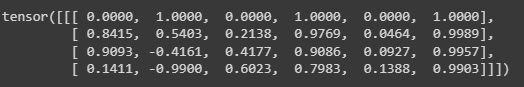

In [ ]:
# Sanity check - III
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

<img src="images\PE Wave.png">

## 2.3 FeedForward Module

The FeedForward Layer in the Transformer architecture is a position-wise neural network layer designed to process the context-aware representations generated by the self-attention mechanism. It consists of two linear transformations followed by a non-linear activation function, typically ReLU.  The FeedForward Layer is applied independently to each position in the sequence, allowing the model to capture different patterns at different positions. This position-wise independence, combined with non-linearity, helps the model learn complex relationships within the data and plays a crucial role in the Transformer's ability to process and understand sequential data effectively, making it a fundamental component for various sequence-to-sequence tasks.

Mathematically, if $X$ represents the input sequence (a sequence of embeddings), $FFN(X)$ is the output of the FeedForward Layer, and $W_1$, $W_2$, $b_1$, and $b_2$ represent learned weight matrices and bias terms, the operation can be expressed as,

\begin{align}
FFN(X) = ReLU(X.W_i + b_i) . W_2 + b_2.
\end{align}

In [ ]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()

        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


In [ ]:
# Sanity Check
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

## 2.4 Encoder Module

The Encoder module in a Transformer is responsible for processing the input sequence, typically used for tasks like language understanding and representation learning. It consists of multiple identical layers, each containing two main components: the Multi-Head Self-Attention mechanism and the Position-wise FeedForward Layer.

<img src="images\Encoder-module.png" width="300">

*   In each layer, the input sequence is first passed through the Multi-Head Self-Attention mechanism, which computes weighted representations for each element in the sequence, capturing contextual information.The attention output is then passed through the Position-wise FeedForward Layer, introducing non-linearity and allowing the model to capture different patterns at each position.
*   This process is repeated for each layer in the encoder stack, enabling the model to capture hierarchical features and   within the input sequence effectively. The final encoder output represents a rich contextualized representation of the input sequence, which can be used for various downstream tasks, including translation, text generation, and sentiment analysis.


### 2.4.1 Encoder Cell

In [ ]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        ###########################################################################
        # TODO: A single Transformer encoder cell consists of
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm
        #                                                                         #
        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        self.attention = None

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        """

        y = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts. Append the        #
        # 1st Normalized Output before feed_forward to self.attention(Useful in   #
        # visualizing)                                                            #
        ###########################################################################

        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y

In [ ]:
# Sanity Check

x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

### 2.4.2 Building an Encoder Module

In [ ]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()

        self.norm = None # LayerNorm layer
        self.cells = None # TransformerEncoderCells

        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerEncoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList

        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """

        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerEncoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y


## 2.5 Transformer Classifier

Now, lets put this all the above describled modules together to make out classifier

In [ ]:
class TransformerClassifier(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self,
            vocab_size: int, embed_dim: int, num_heads: int, trx_ff_dim: int,
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(TransformerClassifier, self).__init__()

        self.embed_dim = embed_dim

        # word embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_token)

        ###########################################################################
        # TODO: Define a module for positional encoding, Transformer encoder, and #
        # a output layer                                                          #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, text, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """

        # word embeddings, note we multiple the embeddings by a factor
        embedded = self.embedding(text) * math.sqrt(self.embed_dim)

        logits = None
        ###########################################################################
        # TODO: Apply positional embedding to the input, which is then fed into   #
        # the encoder. Average pooling is applied then to all the features of all #
        # tokens. Finally, the logits are computed based on the pooled features.  #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return logits

In [ ]:
# Sanity Check
vocab_size = 10
embed_dim = 16
num_heads = 4
trx_ff_dim = 16
num_trx_cells = 2
num_class = 3

x = torch.arange(vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
mask = (x != 0).unsqueeze(-2).unsqueeze(1)
model = TransformerClassifier(vocab_size, embed_dim, num_heads, trx_ff_dim, num_trx_cells, num_class)
print('x: {}, mask: {}'.format(x.shape, mask.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == num_class
print(y.shape)

## 2.6 Deciding HyperParameters & Training

In [ ]:
assert torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 3 # epoch
lr = 0.0005  # learning rate
batch_size = 64 # batch size for training

train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64

num_heads = 4
num_trx_cells = 2

gradient_norm_clip = 1

###########################################################################
# Define a Transformer-based text classifier and a loss function.         #
###########################################################################
raise NotImplementedError
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-8)
total_accu = None

# You should be able to get a validation accuracy around 89%
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, gradient_norm_clip, optimizer)
    accu_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

# Section 3: Transformers - 'Attention is All you need' : Machine Translation

<img src="images\Decoder-module.png" width=500>

The decoder module in a Seq-Seq Transformer model is responsible for generating the output sequence based on the information gathered by the encoder and previous tokens in an autoregressive manner. It utilizes self-attention mechanisms with masking to enforce causality and multi-head attention to capture dependencies between tokens in the output. Self-attention calculates attention weights for each position in the sequence, and multi-head attention aggregates the results from multiple attention heads, enhancing the model's representational power. Cross-attention is also employed to allow the decoder to focus on relevant parts of the encoder's output.

Additionally, position-wise feed-forward networks further process the information by applying linear transformations and non-linear activation functions to each position independently. Throughout the decoder, layer normalization and residual connections are utilized to enhance training stability. These components are typically stacked in multiple layers to enable the model to learn complex relationships and generate coherent output sequences.


### 3.1.1 Decoder Cell

In [ ]:
class TransformerDecoderCell(nn.Module):
    """
    A single cell (unit) of the Transformer decoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerDecoderCell, self).__init__()

        ###########################################################################
        # TODO: Similar to the TransformerEncoderCell, define two                 #
        # MultiHeadAttention modules. One for processing the tokens on the        #
        # decoder side. The other for getting the attention across the encoder.   #
        # and the decoder. Also define a feedforward network. Don't forget the    #
        # Dropout and Layer Norm layers.                                          #
        ###########################################################################

        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None):
        """
        Inputs:
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side

        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """

        y = None
        ###########################################################################
        # TODO: Compute the self-attended features for the tokens on the decoder  #
        # side. Then compute the corss-attended features for the tokens on the    #
        # decoder side to the encoded features, which are finally feed into the   #
        # feedforward network                                                     #
        ###########################################################################

        raise NotImplementedError

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y

In [ ]:
# Sanity Check

dec_feats = torch.randn((3, 10, 16))
dec_mask = torch.randn((3, 1, 10, 10)) > 0.5

enc_feats = torch.randn((3, 12, 16))
enc_mask = torch.randn((3, 1, 1, 12)) > 0.5

model = TransformerDecoderCell(16, 2, 32, 0.1)
z = model(dec_feats, enc_feats, enc_mask, dec_mask)
assert len(z.shape) == len(dec_feats.shape)
for dim_z, dim_x in zip(z.shape, dec_feats.shape):
    assert dim_z == dim_x
print(z.shape)

### 3.1.2 Building the Decoder Module

In [ ]:
class TransformerDecoder(nn.Module):
    """
    A TransformerDecoder is a stack of multiple TransformerDecoderCells and a Layer Norm.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: How many TransformerDecoderCells in stack
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerDecoder, self).__init__()

        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerDecoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList

        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        raise NotImplementedError

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None):
        """
        Inputs:
        - x: Tensor of BxLdxC, word embeddings on the decoder side
        - encoder_output: Tensor of BxLexC, word embeddings on the encoder side
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side

        Return:
        - y: Tensor of BxLdxC. Attended features for all tokens on the decoder side.
        """

        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerDecoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################
        raise NotImplementedError

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return y

In [ ]:
# Sanity Check
dec_feats = torch.randn((3, 10, 16))
dec_mask = torch.randn((3, 1, 10, 10)) > 0.5

enc_feats = torch.randn((3, 12, 16))
enc_mask = torch.randn((3, 1, 1, 12)) > 0.5

model = TransformerDecoder(16, 2, 32, 2, 0.1)
z = model(dec_feats, enc_feats, enc_mask, dec_mask)
assert len(z.shape) == len(dec_feats.shape)
for dim_z, dim_x in zip(z.shape, dec_feats.shape):
    assert dim_z == dim_x
print(z.shape)

## 3.2 Transformer Based Seq-to-Seq Model

In [ ]:
class Seq2SeqTransformer(nn.Module):
    """
    Transformer-based sequence-to-sequence model.
    """
    def __init__(self,
            num_encoder_layers: int, num_decoder_layers: int, embed_dim: int,
            num_heads: int, src_vocab_size: int, tgt_vocab_size: int,
            trx_ff_dim: int = 512, dropout: float = 0.1, pad_token: int=0
        ):
        """
        Inputs:
        - num_encoder_layers: How many TransformerEncoderCell in stack
        - num_decoder_layers: How many TransformerDecoderCell in stack
        - embed_dim: Word embeddings dimension
        - num_heads: Number of attention heads
        - src_vocab_size: Number of tokens in the source language vocabulary
        - tgt_vocab_size: Number of tokens in the target language vocabulary
        - trx_ff_dim: Hidden dimension in the feedforward network
        - dropout: Dropout ratio
        """
        super(Seq2SeqTransformer, self).__init__()

        self.embed_dim = embed_dim

        # Word embeddings for both the source and target languages
        self.src_token_embed = nn.Embedding(src_vocab_size, embed_dim, padding_idx=pad_token)
        self.tgt_token_embed = nn.Embedding(tgt_vocab_size, embed_dim, padding_idx=pad_token)

        ###########################################################################
        # TODO: Define the positional encoding, encoder, decoder, and the output  #
        # layer. Think of how many classes are in the output layer.               #
        ###########################################################################
        raise NotImplementedError
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: torch.Tensor, tgt_mask: torch.Tensor):
        """
        Inputs:
        - src: Tensor of BxLe, word indexes in the source language
        - tgt: Tensor of BxLd, word indexes in the target language
        - src_mask: Tensor, masks of the tokens on the encoder side
        - tgt_mask: Tensor, masks of the tokens on the decoder side

        Return:
        - y: Tensor of BxLdxK. K is the number of classes in the output.
        """

        # Get word embeddings. Note they are scaled.
        src_embed = self.src_token_embed(src) * math.sqrt(self.embed_dim)
        tgt_embed = self.tgt_token_embed(tgt) * math.sqrt(self.embed_dim)

        logits = None
        ###########################################################################
        # TODO: Add positional encodings to the word embeddings. Feed them then   #
        # to the encoder and decoder, respectively. Get the logits finally.       #
        ###########################################################################
        raise NotImplementedError



        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return logits

    def encode(self, src:  torch.Tensor, src_mask:  torch.Tensor):
      src_embed = self.src_token_embed(src) * math.sqrt(self.embed_dim)
      return self.transformer_encoder(self.positional_encoding(src_embed), src_mask)

    def decode(self, tgt:  torch.Tensor, memory:  torch.Tensor, src_mask:  torch.Tensor, tgt_mask:  torch.Tensor):
      tgt_embed = self.tgt_token_embed(tgt) * math.sqrt(self.embed_dim)
      return self.transformer_decoder(self.positional_encoding(tgt_embed), memory, src_mask, tgt_mask)

In [ ]:
src_vocab_size = 10
src = torch.arange(src_vocab_size).view(1, -1)
src = torch.cat((src, src), dim=0)
src_mask = torch.randn((2, 1, 1, src_vocab_size)) > 0.5

tgt_vocab_size = 12
tgt = torch.arange(tgt_vocab_size).view(1, -1)
tgt = torch.cat((tgt, tgt), dim=0)
tgt_mask = torch.randn((2, 1, tgt_vocab_size, tgt_vocab_size)) > 0.5

model = Seq2SeqTransformer(2, 2, 16, 2, src_vocab_size, tgt_vocab_size, 32, 0.1, 0)
z = model(src, tgt, src_mask, tgt_mask)
print(z.shape)

## Utility

Attention Mask

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


def create_mask(src, tgt, pad_token=0):
    src_mask = (src != pad_token).unsqueeze(-2).unsqueeze(1)

    tgt_seq_len = tgt.shape[0]
    tgt_mask = (tgt != pad_token).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequent_mask(tgt.shape[1]).type_as(tgt_mask.data)

    return src_mask, tgt_mask.unsqueeze(1)

In [ ]:
# Let's visualize what the target mask looks like

sns.set_context(context="talk")

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].numpy())

x = torch.arange(src_vocab_size).view(1, -1)
x = torch.cat((x, x), dim=0)
src_mask, tgt_mask = create_mask(x, x)
print(src_mask.shape, tgt_mask.shape)

## Data Loader

In [ ]:
from torchtext.datasets import multi30k, Multi30k

# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset
multi30k.MD5["test"] = "6d1ca1dba99e2c5dd54cae1226ff11c2551e6ce63527ebb072a1f70f72a5cd36"

data_train = Multi30k(split='train')
data_val = Multi30k(split='valid')
data_test = Multi30k(split='test')

In [ ]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# # Create source and target language tokenizer. Make sure to install the dependencies.

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln], #Tokenization
        vocab_transform[ln], #Numericalization
        tensor_transform # Add BOS/EOS and create tensor
    )


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch.transpose(0, 1), tgt_batch.transpose(0, 1)

In [ ]:
BATCH_SIZE = 8

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

for idx, (src, tgt) in enumerate(train_dataloader):
    if idx > 2:
        break
    print('src: {}, tgt: {}'.format(src.shape, tgt.shape))

## 3.3 Model HyperParameters & Training

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMBED_SIZE = 512
NUM_ATTN_HEADS = 8
FF_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = None
###########################################################################
# TODO: Define the model and loss function.                               #
# Note that this time we will generate tokens, where some of them in the  #
# training time are from paddings. We don't want to penalize the model    #
# if the output at such positions are wrong. You can use the              #
# `ignore_index` in a loss function to suppress loss computation if the   #
# ground-truth label is equal to the given value. Check here for          #
# more details https://pytorch.org/docs/stable/nn.html#loss-functions     #
###########################################################################
raise NotImplementedError

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
transformer = transformer.to(device)

optimizer = torch.optim.Adam(
    transformer.parameters(),
    lr=0.0001,
    betas=(0.9, 0.98),
    eps=1e-9
)

In [ ]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0

    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask = create_mask(src, tgt_input)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)

        logits = model(src, tgt_input, src_mask, tgt_mask)

        optimizer.zero_grad()

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask)

        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

from timeit import default_timer as timer

NUM_EPOCHS = 10

# You should be able to get train loss around 1.5 and val loss around 2.2
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


## Greedy Translate/Decode

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.float).to(device)
    for i in range(max_len-1):

        memory = memory.to(device)
        tgt_mask = (subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(device)
        cross_mask = torch.ones(1,i + 1,src.size(1), device=device)
        out = model.decode(ys.long(), memory, cross_mask, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.output_layer(out[:, -1])
        _, next_word = torch.max(prob[-1,:], dim=0)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()

    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(1, num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens, model = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX)

    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.flatten().cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
src_sentence = "Eine Gruppe von Menschen steht vor einem Iglu ."
translate(transformer, src_sentence)